In [2]:
import pandas as pd
import numpy as np
import re
# from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")


2025-03-26 17:05:13.937497: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 17:05:14.080463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743026714.147755    3027 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743026714.166663    3027 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743026714.277510    3027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
df = pd.read_excel("data/cleaning.xlsx")

In [4]:
# compute number of day elapsed between calls
df = df.sort_values(by=["match_id", "completion_date"])
df['ndays_between_call'] = df.groupby("match_id")["completion_date"].diff().dt.days

df.fillna(0, inplace=True)

In [5]:
gap_stats = df.groupby('match_id')['ndays_between_call'].agg(['mean', 'max', 'std', 'count']).reset_index()
gap_stats.rename(
    columns={
        "mean": "avg_cadence_day",
        "max": "max_cadence_day",
        "count": "call_count"
    }
    ,inplace=True
)
gap_stats = gap_stats.fillna(0)
gap_stats


,match_id,avg_cadence_day,max_cadence_day,std,call_count
0,a1v2J0000027CWYQA2,35.000000,56.0,30.512293,3
1,a1v2J0000027CWfQAM,46.200000,83.0,30.202649,5
2,a1v2J0000027CWiQAM,35.333333,65.0,32.868425,3
3,a1v2J0000027CWoQAM,43.750000,106.0,46.334832,4
4,a1v2J0000027CWpQAM,45.750000,85.0,35.668614,4
...,...,...,...,...,...
3259,a1vUX000001ZI7xYAG,11.666667,28.0,14.571662,3
3260,a1vUX000001ZICnYAO,0.000000,0.0,0.000000,1
3261,a1vUX000001agjJYAQ,0.000000,0.0,0.000000,1
3262,a1vUX000001avDhYAI,0.000000,0.0,0.000000,1


In [6]:
df = pd.merge(df, gap_stats, on="match_id", how="left")


In [7]:
mean = df["avg_cadence_day"].corr(df["match_length"])
maxe = df["max_cadence_day"].corr(df["match_length"])
std = df["std"].corr(df["match_length"])
count = df["call_count"].corr(df["match_length"])

print(mean, maxe, std, count)

0.7488531105247069 0.610920380234909 0.45133404256676707 0.9257783798730321


In [8]:

# Function to split early and late stage call notes
def split_call_notes(match_df):
    num_calls = len(match_df)
    
    # Edge case: no calls or only one call
    if num_calls == 0:
        return pd.Series(["unavailable", "unavailable"], index=["early_stage_notes", "late_stage_notes"])
    
    elif num_calls == 1:
        return pd.Series([match_df["contact_notes"].iloc[0], "unavailable"],index=["early_stage_notes", "late_stage_notes"])
    
    # Split the match calls into early and late stages based on call count
    early_stage = match_df.head(num_calls // 2)["contact_notes"].str.cat(sep=" ")  # First 50% of the calls
    late_stage = match_df.tail(num_calls - (num_calls // 2))["contact_notes"].str.cat(sep=" ")  # Remaining calls
    
    return pd.Series([early_stage, late_stage], index=["early_stage_notes", "late_stage_notes"])

# Apply the function for each match and concatenate
df_grouped = df.groupby("match_id").apply(split_call_notes).reset_index()

# Merge back with the original dataframe
df_final = pd.merge(df, df_grouped, on="match_id", how="left")


In [9]:
# dropped used columns
data = df_final.drop(['completion_date', 'contact_notes', "ndays_between_call"], axis=1).groupby("match_id").first().reset_index()

In [10]:
# Text Preprocessing Function
def preprocess(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    return text

In [11]:
data['early_stage_notes'] = data['early_stage_notes'].apply(preprocess)
data['late_stage_notes'] = data['late_stage_notes'].apply(preprocess)

# Convert texts into TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data['early_stage_notes'].tolist() + data['late_stage_notes'].tolist())

# Split into early and late vectors
num_matches = len(data)
early_tfidf = tfidf_matrix[:num_matches]
late_tfidf = tfidf_matrix[num_matches:]

# Compute Cosine Similarity between early and late notes
similarity_scores = [cosine_similarity(early_tfidf[i], late_tfidf[i])[0, 0] for i in range(num_matches)]

# Add topic consistency scores to DataFrame
data['topic_consistency'] = similarity_scores

In [12]:
data['topic_consistency']

0       0.520978
1       0.864096
2       0.592739
3       0.371766
4       0.702796
          ...   
3259    0.314136
3260    0.000000
3261    0.000000
3262    0.000000
3263    0.557844
Name: topic_consistency, Length: 3264, dtype: float64

In [13]:
topic = data["topic_consistency"].corr(data["match_length"])
print(topic)

0.28216065667507606


In [14]:
# Download VADER Lexicon (if not already downloaded)
nltk.download("vader_lexicon")

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/amen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
### **5️⃣ Assign Broad Match Categories**
keywords = {
    "shared_interest": [
        "love", "like", "enjoy", "passion", "hobby", "interest", "games",
        "sports", "music", "movies", "books", "reading", "art", "drawing",
        "painting", "writing", "creative", "dancing", "theater", "acting",
        "outdoors", "hiking", "camping", "travel", "adventure", "photography",
        "fitness", "exercise", "gym", "technology", "coding", "anime", "gaming",
        "board games", "strategy games", "puzzle", "cooking", "baking"
    ],
    
    "career": [
        "career", "job", "work", "goal", "future", "internship", "education",
        "college", "university", "study", "skills", "learning", "profession",
        "aspiration", "training", "employment", "resume", "interview", "networking",
        "mentorship", "scholarship", "certification", "growth", "promotion",
        "company", "business", "entrepreneur", "freelance", "industry", "field",
        "research", "technology", "engineering", "medical", "law", "finance",
        "science", "teaching", "management", "leadership", "trade", "construction",
        "coding", "startup", "job market", "salary", "income"
    ],
    
    "location": [
        "neighborhood", "city", "state", "close", "near", "distance",
        "same area", "nearby", "local", "region", "town", "village", "suburb",
        "downtown", "urban", "rural", "relocate", "move", "transportation",
        "commute", "drive", "bus", "train", "subway", "car", "bike", "walking",
        "travel time", "home", "apartment", "house", "living situation"
    ],
    
    "family": [
        "single parent", "siblings", "family", "home", "mom", "dad", "guardian",
        "grandparents", "cousins", "aunt", "uncle", "foster", "adoption",
        "step-parent", "step-sibling", "relative", "household", "parents",
        "childhood", "raising", "support system", "home life", "kids", "parenting",
        "family values", "responsibility", "brother", "sister", "niece", "nephew"
    ],
    
    "volunteering": [
        "volunteer", "help", "community", "leadership", "giving back",
        "nonprofit", "charity", "service", "mentor", "tutor", "teaching",
        "fundraising", "social work", "outreach", "activism", "advocacy",
        "awareness", "support", "public service", "coaching", "guidance",
        "mentorship", "helping others", "environmental work", "animal shelter",
        "soup kitchen", "homeless", "donation", "relief work", "medical aid",
        "youth program", "elderly care", "social good", "positive impact",
        "teamwork", "organizing", "initiatives", "volunteer work"
    ]
}


def categorize_match(text):
    text = text.lower()
    categories = {key: any(word in text for word in words) for key, words in keywords.items()}
    return categories

df_categories = data["rationale_for_match"].apply(categorize_match).apply(pd.Series)
data = pd.concat([data, df_categories], axis=1)

In [16]:
data

,match_id,big_age,big_occupation,big_gender,program,program_type,big_race_ethnicity,rationale_for_match,little_gender,little_participant__race_ethnicity,...,std,call_count,early_stage_notes,late_stage_notes,topic_consistency,shared_interest,career,location,family,volunteering
0,a1v2J0000027CWYQA2,25,Student: High School,Female,YIP 2016,Site,Asian;,"Big, little and parent were in agreement with ...",Female,Asian,...,30.512293,3,question activities answer bs assists ls with ...,question activities answer when asked who deci...,0.520978,True,False,True,False,False
1,a1v2J0000027CWfQAM,26,Student: College,Female,YIP 2016,Site,White or Caucasian;,"Both seem to like the arts, books, and present...",Female,Black or African American,...,30.202649,5,question activities answer sami and l_first_na...,question activities answer l_first_name and sa...,0.864096,True,False,False,False,False
2,a1v2J0000027CWiQAM,27,Student: High School,Female,YIP 2016,Site,Asian;,Both BS and LB share similar interests. BS has...,Female,Asian,...,32.868425,3,question activities answer bs has been consist...,question activities answer bs said she has bee...,0.592739,True,False,False,False,False
3,a1v2J0000027CWoQAM,25,Student: High School,Female,YIP 2016,Site,Asian;,B_first_name was open to the little that he is...,Female,Asian,...,46.334832,4,question activities answer bs played games wit...,question activities answer this match particip...,0.371766,True,False,False,False,False
4,a1v2J0000027CWpQAM,27,Student: College,Male,YIP 2016,Site,White or Caucasian;,Distance is 8 miles (21 mins). Both are talkti...,Male,Black or African American,...,35.668614,4,question activities answer b_first_name and l_...,question activities answer b_first_name and l_...,0.702796,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3259,a1vUX000001ZI7xYAG,38,Medical: Nurse,Female,STEM Cohort 2025,Community,White or Caucasian;,Distance: 13 min (4.6 mi) Shared Interests: sp...,Female,Black or African American,...,14.571662,3,you 4 56 pm hi b_first_name this is kelley nel...,approximately how many times has your match go...,0.314136,True,True,True,False,False
3260,a1vUX000001ZICnYAO,56,Business: Marketing,Female,STEM Cohort 2025,Community,White or Caucasian;,1. Distance: 10 miles (20 mins) 2. Shared Trai...,Female,White or Caucasian,...,0.000000,1,approximately how many times has your match go...,unavailable,0.000000,True,False,True,False,True
3261,a1vUX000001agjJYAQ,33,Business: Marketing,Female,General Community,Community,Asian - Other;,1. Distance: 9 miles (20 mins) 2. Shared Trait...,Female,Black or African American,...,0.000000,1,mec connected with big on 1 13 4p mec asked ho...,unavailable,0.000000,True,False,True,False,False
3262,a1vUX000001avDhYAI,48,Business: Sales,Male,General Community,Community,White or Caucasian;,Distance: 9 min (3.7 mi) Shared interests:Spor...,Male,Black or African American,...,0.000000,1,mec called bb at the scheduled time bb express...,unavailable,0.000000,True,False,True,False,False


In [17]:
# Function to compute sentiment score
def get_sentiment(text):
    if text == "unavailable":  # Handle missing data
        return 0.0
    return sia.polarity_scores(text)["compound"]

# Compute sentiment scores for early and late stages
data["early_stage_score"] = data["early_stage_notes"].apply(get_sentiment)
data["late_stage_score"] = data["late_stage_notes"].apply(get_sentiment)

data.reset_index(inplace=True)

In [18]:
# Compute sentiment change
data["sentiment_change"] = data["late_stage_score"] - data["early_stage_score"]
data["sentiment_change"] 

0       0.2265
1      -0.0037
2       0.0330
3      -0.5276
4      -0.0059
         ...  
3259    0.0009
3260   -0.9954
3261   -0.9981
3262   -0.9698
3263    0.0016
Name: sentiment_change, Length: 3264, dtype: float64

In [19]:

# Categorize sentiment trend
def categorize_change(change):
    if change > 0.5:
        return "Improved"
    elif change < -0.5:
        return "Declined"
    else:
        return "Stable"

data["sentiment_trend"] = data["sentiment_change"].apply(categorize_change)
# data["sentiment_trend"]


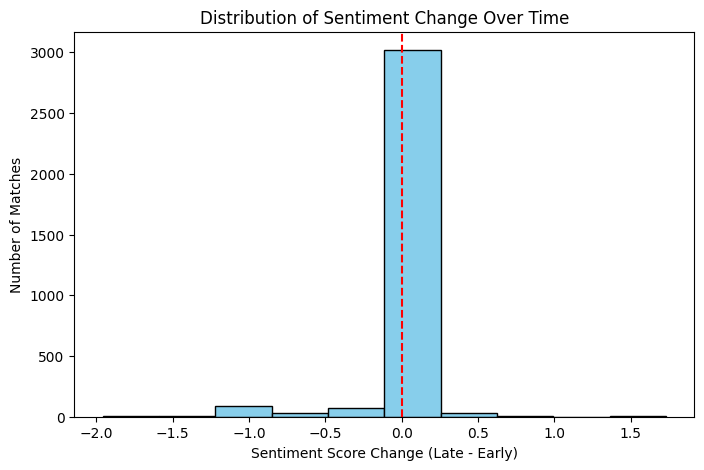

In [20]:
#  Plot sentiment scores
plt.figure(figsize=(8, 5))
plt.hist(data["sentiment_change"], bins=10, color="skyblue", edgecolor="black")
plt.axvline(0, color='red', linestyle="dashed")  # Vertical line at 0
plt.xlabel("Sentiment Score Change (Late - Early)")
plt.ylabel("Number of Matches")
plt.title("Distribution of Sentiment Change Over Time")
plt.show()


In [21]:
# data.to_excel("data/feng.xlsx", index=False)